Step 1: Install Required Python Libraries

In [1]:
# pip install rasterio geopandas matplotlib numpy

  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'E:\OneDrive - M-pesa.Africa\100Human2024\Kobo\kobo_venv\Scripts\python.exe -m pip install --upgrade pip' command.


Step 2: Load and Visualize the GeoTIFF Data

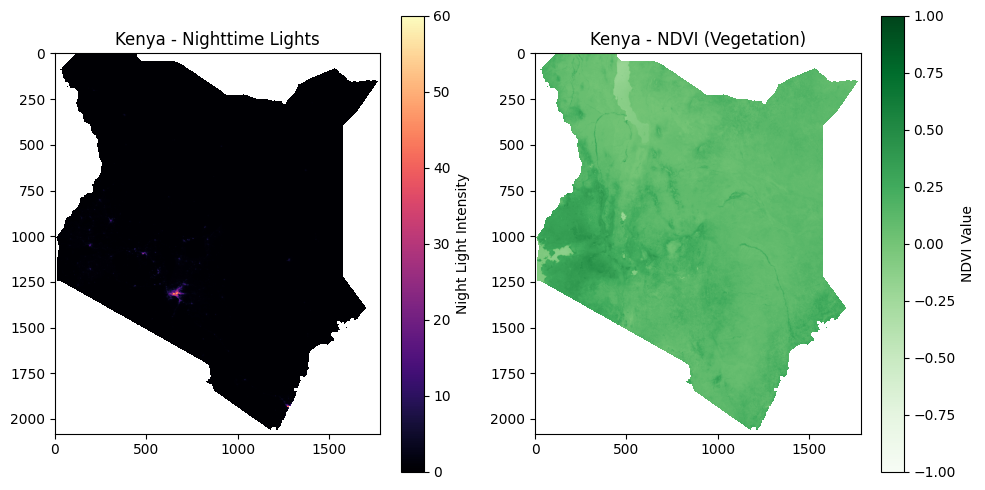

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the GeoTIFF file
file_path = "kenya_poverty_satellite_data.tiff"  # Update with actual path

with rasterio.open(file_path) as dataset:
    # Read the bands
    night_lights = dataset.read(1)  # First band (VIIRS Night Lights)
    ndvi = dataset.read(2)  # Second band (NDVI)

# Plot Night Lights
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(night_lights, cmap="magma", vmin=0, vmax=60)
plt.colorbar(label="Night Light Intensity")
plt.title("Kenya - Nighttime Lights")

# Plot NDVI
plt.subplot(1, 2, 2)
plt.imshow(ndvi, cmap="Greens", vmin=-1, vmax=1)
plt.colorbar(label="NDVI Value")
plt.title("Kenya - NDVI (Vegetation)")

plt.tight_layout()
plt.show()


 Step 3: Extract & Analyze Data

In [4]:
# Remove invalid values
night_lights = night_lights[night_lights > 0]  # Remove no-data values
ndvi = ndvi[(ndvi >= -1) & (ndvi <= 1)]  # NDVI should be in [-1,1]

# Compute statistics
print(f"Night Lights - Mean: {np.mean(night_lights):.2f}, Std Dev: {np.std(night_lights):.2f}")
print(f"NDVI - Mean: {np.mean(ndvi):.2f}, Std Dev: {np.std(ndvi):.2f}")


Night Lights - Mean: 0.41, Std Dev: 1.01
NDVI - Mean: 0.13, Std Dev: 0.09


Step 3: Extract Features for Model Training

In [5]:
import rasterio
import numpy as np
import pandas as pd

# Load GeoTIFF file
file_path = "kenya_poverty_satellite_data.tiff"  # Update this path

with rasterio.open(file_path) as dataset:
    night_lights = dataset.read(1)  # Night Lights band
    ndvi = dataset.read(2)  # NDVI band
    transform = dataset.transform  # Get spatial reference

# Get row/column indices for non-empty pixels
rows, cols = np.where(night_lights > 0)

# Convert pixel indices to geographic coordinates (lat/lon)
lon, lat = rasterio.transform.xy(transform, rows, cols)

# Create DataFrame
data = pd.DataFrame({
    "latitude": lat,
    "longitude": lon,
    "night_lights": night_lights[rows, cols],
    "ndvi": ndvi[rows, cols]
})

# Normalize Night Lights as "poverty score" (inverse relation)
data["poverty_score"] = 1 - (data["night_lights"] / data["night_lights"].max())

# Save to CSV
data.to_csv("kenya_poverty_data.csv", index=False)

print("✅ Data extracted & saved as kenya_poverty_data.csv!")


✅ Data extracted & saved as kenya_poverty_data.csv!


 Step 4: Train a Deep Learning Model

In [7]:
# pip install tensorflow scikit-learn pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'E:\OneDrive - M-pesa.Africa\100Human2024\Kobo\kobo_venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the extracted poverty dataset
data = pd.read_csv("kenya_poverty_data.csv")

# Select features and target variable
X = data[["night_lights", "ndvi"]].values  # Features
y = data["poverty_score"].values  # Target (poverty level)

# Normalize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple Deep Learning model (MLP)
model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")  # Output: poverty score (0-1)
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model.save("poverty_prediction_model.h5")
print("✅ Model training complete and saved as 'poverty_prediction_model.h5'")


Epoch 1/20


E:\OneDrive - M-pesa.Africa\100Human2024\Kobo\kobo_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58819/58819 ━━━━━━━━━━━━━━━━━━━━ 485s 8ms/step - loss: 0.0025 - mae: 0.0090 - val_loss: 4.4272e-05 - val_mae: 7.9086e-04
Epoch 2/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 451s 8ms/step - loss: 5.4551e-05 - mae: 0.0018 - val_loss: 4.6338e-05 - val_mae: 0.0014
Epoch 3/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 546s 9ms/step - loss: 5.0996e-05 - mae: 0.0017 - val_loss: 4.7586e-05 - val_mae: 0.0019
Epoch 4/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 607s 10ms/step - loss: 4.8887e-05 - mae: 0.0010 - val_loss: 4.9414e-05 - val_mae: 0.0025
Epoch 5/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 432s 7ms/step - loss: 4.9325e-05 - mae: 0.0014 - val_loss: 4.7049e-05 - val_mae: 0.0017
Epoch 6/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 552s 9ms/step - loss: 5.2794e-05 - mae: 0.0018 - val_loss: 4.2811e-05 - val_mae: 7.2318e-04
Epoch 7/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 256s 4ms/step - loss: 4.8752e-05 - mae: 0.0015 - val_loss: 4.8423e-05 - val_mae: 0.0022
Epoch 8/20
58819/58819 ━━━━━━━━━━━━━━━━━━━━ 257s 4ms/step - loss: 5.2978e-05 - mae

✅ Model training complete and saved as 'poverty_prediction_model.h5'
